In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import shutil
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
path = "../dataset_blood_group"

In [47]:
BATCH_SIZE = 32

In [48]:
# Step 1: Loading Dataset
dataset = image_dataset_from_directory(
    path,
    labels="inferred",
    image_size=(64, 64), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [4]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution
O+: 852
AB-: 761
O-: 712
A-: 1009
AB+: 708
B+: 652
A+: 565
B-: 741


In [50]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names, class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color=['skyblue', 'lightcoral', 'lightgreen', 'khaki', 'lightpink', 'lightblue', 'grey', 'salmon'])  # Customize colors as needed
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Dataset Class Distributon")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if needed
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    # # Add count labels on top of each bar
    # for bar in bars:
    #     height = bar.get_height()
    #     plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')  # Centered above bar

    # plt.show()

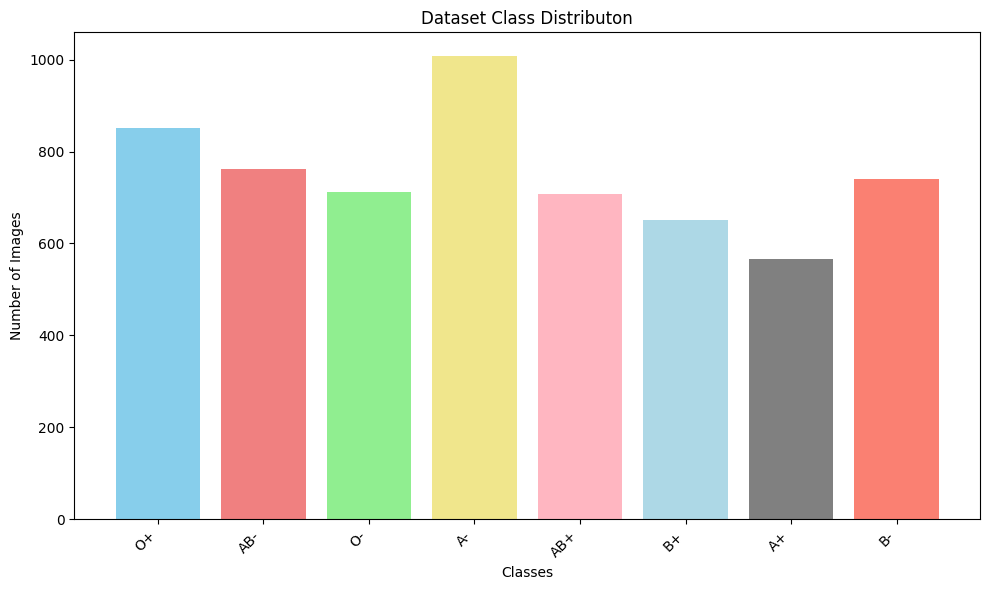

In [51]:
plot_class_distribution(class_names, class_counts)

In [52]:
max_count = max(class_counts.values())
print(max_count)

1009


In [45]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()

    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    # Calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)

    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)

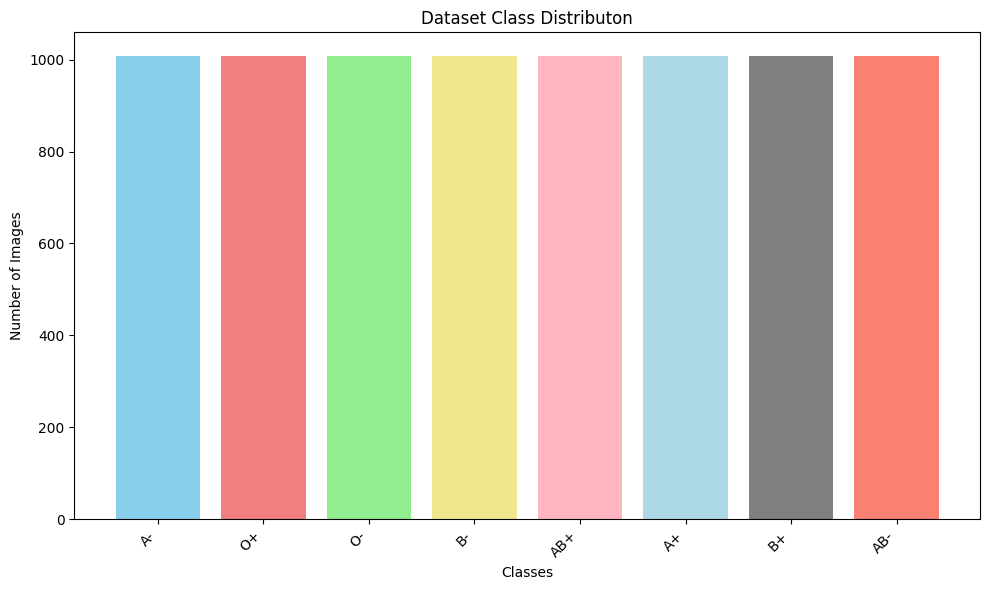

In [53]:
# Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Combine balanced datasets
balanced_datasets = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_datasets])
plot_class_distribution(class_names, balanced_class_counts)

# Batch the balanced dataset
balanced_datasets = balanced_datasets.batch(BATCH_SIZE, drop_remainder=True)

In [55]:
for sample in balanced_datasets.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [57]:
balanced_dataset_unbatched = balanced_datasets.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [60]:
# Define ratios and dataset size
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [ ]:
# Unbatch the dataset to work at the sample level
balanced_dataset_unbatched = balanced_datasets.unbatch()

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")